<a href="https://colab.research.google.com/github/R0N3ldrt/Thesis/blob/main/Revised_NN_predict_v15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traininig NN Spectrum

# Loading Necesary Libraries

In [1]:
# Importing necesary libraries
# Libraries for correct code execution 

import os, time, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import random
import csv
import re
import array
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import os.path
import tensorflow

from scipy import stats
from functools import reduce
from random import random, gauss
from math import modf, pi, cos, sin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr

import scipy.stats as st
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.mixture import GaussianMixture
import os, time, math, csv, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import os, time, math, csv, joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

# Load Enviroment

In [2]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [3]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Change the number to change the paths.
worker = workers[0]

if worker == "Ronald":
  path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

# Get working_df

## Aggregator

In [121]:
def prime_number_finder(stop_gap, total_num_of_data):
  prime_nums = []
  i=2
  while i <= stop_gap:
    if (total_num_of_data % i==0):
      prime_nums.append(i)
      break
    i+=1
  return prime_nums

In [122]:
def aggreagator_v2(df, stop_gap=50):
  total_num_of_data = df.shape[1]
  arr_prime = prime_number_finder(stop_gap, total_num_of_data)
  #agg_num = np.max(arr_prime)
  agg_num = arr_prime[0]

  # Creating new df of aggregate values
  agg_df = pd.DataFrame()

  mid_point = df.shape[1]/2

  agg=0
  loop_cnt=0
  init_column_cnt = 5
  while agg<=total_num_of_data:
    loop_cnt+=1
    # Obtain current last columns stop
    agg=agg_num+init_column_cnt
    # Select working columns
    new_df = df[df.columns[init_column_cnt:agg]]

    init_column_cnt += (agg_num)

    headers = list(new_df.columns.values) 
    if loop_cnt <= mid_point:
      # Get average of freq values for new header
      new_header_name  = headers[-1]
    else:
      new_header_name = headers[0]
    
    # Add aggragated values to new df
    agg_df[new_header_name] = new_df.mean(axis = 1)
  return agg_df

## Find cutoff index

In [123]:
def remove_tail(df, cut_val, sample_id):
  columns_selected = []
  old_val = 0
  delta = 0
  mid_point = int(df.shape[1]/2)
  cols_headers  = list(df.columns.values)

  for i in range(0, df.shape[1]):
    if i == 0:
      cell_val = df.iloc[[0], i]
      old_val = cell_val[sample_id]
    else:
      cell_val = df.iloc[[0], i]
      val = cell_val[sample_id]
      delta = abs(old_val-val)
      old_val = val
      if delta > cut_val:
        if i <= mid_point:
          col_name_selected = cols_headers[i+2]
        else:
          col_name_selected = cols_headers[i-2]
          col_name_selected = round(float(col_name_selected), 5)
        columns_selected.append(col_name_selected)

  return columns_selected

In [124]:
# Removing tails conducting multiples loops with variable cutoff value until we get only two columns
def remove_tail_main(df, cut_val, sample_id):
  old_drop_cols = []
  drop_cols = remove_tail(df, cut_val, sample_id)
  while len(drop_cols) != 2:  
    # If len of columns to be dropped are 0 the select the 2 values smaller and bigger of the previous iteration
    if len(drop_cols) == 0 or len(drop_cols) == 1:
      drop_cols = [np.min(old_drop_cols), np.max(old_drop_cols)]
      break
    else:
      old_drop_cols = drop_cols
      drop_cols = remove_tail(df, cut_val, sample_id)
      cut_val += 2
  return drop_cols

In [125]:
def get_working_data_idx_v2(df_mean_sample, sample_id, cut_val = 0):

  df = df_mean_sample.iloc[[sample_id - 1]]

  agg_df = aggreagator_v2(df)
  col_vals = remove_tail_main(df, cut_val=cut_val, sample_id=sample_id)

  left_index_no = df.columns.get_loc(col_vals[0])
  rigth_index_no = df.columns.get_loc(col_vals[1])

  return left_index_no, rigth_index_no

In [126]:
def cut_off_idx(df): # return tuple with cut-off values (index_left_side, index_rigth_side)
  df_mean_sample = df.groupby(['PBRS_id']).mean()
  df_mean_sample = df_mean_sample.drop(['row', 'Channels', 'Distance_km', 'power_dBm'], axis = 1)

  cut_points = {}
  print('Calculating the cutoff values:')
  for sample in tqdm(df_mean_sample.index):
    left_index_no, rigth_index_no = get_working_data_idx_v2(df_mean_sample, sample_id = sample)
    cut_points[sample] = (left_index_no, rigth_index_no)

  left_cut_off = np.min([v[0] for k, v in cut_points.items()])
  rigth_cut_off = np.max([v[1] for k, v in cut_points.items()])

  cut_point = (left_cut_off, rigth_cut_off)
  return cut_point

## Select working data

In [127]:
def select_working_data(df, cut_point): # implement cut_off values and Smoothing original df after cutt-of
  extra_info_df = df.iloc[:, 0:6]
  data_df = df.iloc[:, cut_point[0]+6:cut_point[1]+6]
  #smoothed_data_frame = pd.DataFrame(savgol_filter(data_df, window_length = 5, polyorder = 2))
  
  # Adding back headers to the smoothed data
  rename_col = {}
  cnt = 0
  for col in data_df.columns:
    h_col = round(float(col), 5)
    rename_col[cnt] = h_col
    cnt += 1
  #smoothed_data_frame.rename(columns=rename_col, inplace=True)

  working_df = pd.merge(extra_info_df, data_df, left_index=True, right_index=True)
  return working_df

In [136]:
def main_cutoff(input_path, manual_cutoff=(False, 200, 200)):
  print('Reading data from file...')
  df = pd.read_excel(input_path, sheet_name = "Sheet1", skiprows=1)
  print('Cleaning data...')
  df.iloc[0].fillna(method='bfill', inplace=True)

  #df.iloc[1:df.shape[0]].fillna(method='pad', inplace=True)
  # Adding missing PBRS_id
  snippet = []
  val_cnt = 1
  idx = 0
  for sample in range(1, 101):
    for sample_id in range(0, 25):
      df.at[idx, 'PBRS_id'] = val_cnt
      idx +=1
      snippet.append(val_cnt)
    val_cnt += 1
  df['PBRS_id'] = df['PBRS_id'].astype(int)

  df = df.dropna() # remove nan rows

  if manual_cutoff[0] == False:
    cut_point = cut_off_idx(df)
  else:
    df = aggreagator_v2(df)
    cut_point = cut_off_idx(manual_cutoff[1], manual_cutoff[2])
  working_df = select_working_data(df, cut_point)

  return working_df

## Run main cutoff

In [ ]:
'''
input_path = path + "/Spectrum/16QAM_v2/Copy of dataSet_gamma0_Spectrum31MHz_Samples_16QAM_75GHz_LongHaul_input_25x81km_primeStep.xlsx"

working_df = main_cutoff(input_path, manual_cutoff=(False, 200, 200))
display(working_df)
'''

In [137]:
#working_df.to_csv(path+"/Spectrum/NN/new_data_working_df.csv", index=False)

# Bootstrapping

## Get max and min values of each column

In [96]:
def get_max_min_val_col(working_df):
  distances = [x*80 for x in range(1, 26)]
  data_working_df = working_df.iloc[:, 6:working_df.shape[1]]
  h_list = list(data_working_df.columns.values)
  max_min_col_dict = {header:[] for header in h_list}

  for d in tqdm(distances):
    boot_dist_df = working_df.loc[working_df['Distance_km'] == d]
    for idx in range(6, boot_dist_df.shape[1]):
      max_val_col = float(boot_dist_df.iloc[:, [idx]].max()) # max val in col
      min_val_col = float(boot_dist_df.iloc[:, [idx]].min()) # min val in col
      h = boot_dist_df.iloc[:, [idx]].columns # header of col
      h = h[0]
      max_min_col_dict[h].append((d, min_val_col, max_val_col))
  return max_min_col_dict

## Create new samples using bootstrap technique

In [97]:
def create_bootstrap_samples(working_df, max_min_col_dict, target_amt_of_samples=100):
  import random
  row_data = []
  PBRS_id_data = []
  Distance_km_data = []
  power_dBm_data = []
  span_data = []
  
  distances = [x*80 for x in range(1, 26)]

  h_list = list(working_df.columns.values)
  new_data = {header:[] for header in h_list}

  last_row_in_old_df_val = working_df.shape[0] + 1
  #for new_sample in tqdm(range(num_of_new_samples)): # generating (num_of_new_samples) new samples for en data
  for d in tqdm(distances):
    current_distance_samples = working_df.loc[working_df['Distance_km'] == d]

    for new_sample_cnt in range(1, target_amt_of_samples+1):
      filtered_values = np.where((working_df['PBRS_id']==new_sample_cnt) & (working_df['Distance_km']== d))
      if len(filtered_values[0]) == 0: # check if do not have already a value present
        new_data['row'].append(last_row_in_old_df_val)
        last_row_in_old_df_val += 1
        new_data['PBRS_id'].append(new_sample_cnt)

        new_data['Channels'].append(1)
        new_data['Distance_km'].append(d)
        new_data['power_dBm'].append(0)
        new_data['#span'].append(int(d/80))

        for k, v in max_min_col_dict.items(): # header:(d, min_val_col, max_val_col)
          for val in v:
            if val[0] == d:
              bootstrap_val = round(random.uniform(val[1], val[2]), 14)
              new_data[str(k)].append(bootstrap_val)
              break
  new_data_df = pd.DataFrame.from_dict(new_data)

  return new_data_df

## Combine previos df with bootstraped df

In [98]:
'''
input_path = path + "/Spectrum/NN/new_data_working_df.csv"
working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)

print('Get max min for each distance...')
max_min_col_dict = get_max_min_val_col(working_df)
                                       
print('Creating new samples...')
new_data_df = create_bootstrap_samples(working_df, max_min_col_dict, target_amt_of_samples=100)
new_working_df = working_df.append(new_data_df)
new_working_df = new_working_df.sort_values(['PBRS_id', 'Distance_km'], ascending=[True, True])

new_working_df.to_csv(path + "/Spectrum/NN/bootstraped_new_data_working_df.csv", index=False)
new_working_df
'''

Get max min for each distance...


100%|██████████| 25/25 [01:19<00:00,  3.20s/it]


Creating new samples...


100%|██████████| 25/25 [00:21<00:00,  1.16it/s]


,row,PBRS_id,Channels,Distance_km,power_dBm,#span,-39.90625,-39.875,-39.84375,-39.8125,...,23.09375,23.125,23.15625,23.1875,23.21875,23.25,23.28125,23.3125,23.34375,23.375
0,301,1,1,80,0,1,-61.498384,-69.375394,-56.940445,-56.521270,...,-15.381299,-16.345456,-9.588697,-24.214851,-15.703513,-15.224552,-11.972055,-25.566033,-12.708850,-18.710169
88,389,1,1,160,0,2,-48.619100,-62.894364,-47.022241,-42.089478,...,-12.507582,-22.825079,-13.014941,-8.669048,-13.016946,-19.788373,-10.152750,-26.386770,-8.599328,-11.231857
176,477,1,1,240,0,3,-46.482009,-36.005924,-42.616328,-43.035038,...,-10.348420,-8.273268,-4.045445,-24.864025,-18.612676,-8.753890,-16.931066,-18.611469,-16.641389,-5.972412
264,565,1,1,320,0,4,-54.144569,-40.683577,-41.575832,-45.445372,...,-14.939094,-7.769422,-11.734977,-19.157006,-12.306752,-11.612236,-12.592409,-16.259989,-14.151617,-6.743659
352,653,1,1,400,0,5,-49.718368,-47.185962,-38.853902,-36.879778,...,-12.818315,-15.678434,-9.672318,-9.110974,-18.166565,-7.356050,-12.020958,-26.164988,-10.448483,-16.972357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,2148,100,1,1680,0,21,-39.605213,-38.504981,-28.422156,-65.236600,...,-14.216245,-13.297177,-7.943607,-13.362270,-14.918324,-8.056035,-9.923285,-11.876975,-14.833822,-6.917744
1935,2236,100,1,1760,0,22,-30.242049,-38.658710,-29.246003,-42.629668,...,-8.502492,-10.175865,-3.479548,-18.012542,-6.075202,-25.337653,-6.417492,-16.533271,-36.043136,-11.692240
2023,2324,100,1,1840,0,23,-28.562704,-43.343401,-30.956476,-51.458208,...,-8.600486,-5.257353,-9.957699,-13.280819,-5.256372,-24.175765,-3.245541,-23.303109,-29.603712,-4.517909
2111,2412,100,1,1920,0,24,-39.441770,-30.712885,-30.058500,-36.081678,...,-5.852259,-8.260202,-9.150114,-9.492350,-13.771802,-24.585106,-14.402555,-5.085497,-22.513548,-8.426101


# New version train test split

In [99]:
'''
input_path = path + "/Spectrum/NN/bootstraped_new_data_working_df.csv"
working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)
working_df
'''

'\ninput_path = path + "/Spectrum/NN/bootstraped_new_data_working_df.csv"\nworking_df = pd.read_csv(input_path)\nworking_df[\'Distance_km\'] = working_df[\'Distance_km\'].astype(int)\nworking_df\n'

## Freq filter

In [100]:
def frequencies_filter(df, num_selected_freq=20):
  info_df = df.iloc[:, [0,1]]
  data_df = df.iloc[:, 1:df.shape[1]]
  span_val = int(data_df.shape[1]/num_selected_freq)
  for i in range(0, num_selected_freq):
    df2 = data_df.iloc[:, (i+1)*span_val].to_frame()
    if i+1 == 1:
      new_df = df2
    else:
      new_df = pd.merge(new_df, df2, left_index=True, right_index=True)
  new_df = info_df.join(new_df)
  
  return new_df

def get_data(working_df, distances, num_features = 20, span_length=80, min_dist = 0, max_dist = 2000):
  X=None
  Y=np.array([])
  id_df = working_df.iloc[:, 1]
  dist_df = working_df.iloc[:, 3]
  freq_df = working_df.iloc[:, 6:working_df.shape[1]]

  id_dist_df = pd.merge(id_df, dist_df, left_index=True, right_index=True)
  samples_df = pd.merge(id_dist_df, freq_df, left_index=True, right_index=True)

  if num_features != 'all':
    samples_df = frequencies_filter(samples_df, num_selected_freq = num_features)
  Y = samples_df.iloc[:, 1].to_numpy().astype('int').tolist()
  X = samples_df.iloc[:, 2:samples_df.shape[1]]
  
  return X, Y, samples_df

In [101]:
'''
distances = [x*80 for x in range(1, 26)]
X, Y, samples_filtered_df = get_data(working_df, distances, num_features = 20, span_length=80,  min_dist = 0, max_dist = 2000)
samples_filtered_df
'''

'\ndistances = [x*80 for x in range(1, 26)]\nX, Y, samples_filtered_df = get_data(working_df, distances, num_features = 20, span_length=80,  min_dist = 0, max_dist = 2000)\nsamples_filtered_df\n'

## Reference split

In [102]:
def get_reference_and_sample_data_split(samples_filtered_df, num_reference=30):
  import random
  num_of_ids = len(samples_filtered_df['PBRS_id'].unique())

  l = list(range(1, num_of_ids+1))
  random.shuffle(l)
  reference_arr = (l[:num_reference]) # selecting first "num_reference" random values
  sample_arr = l[-(num_of_ids-num_reference):]

  reference_data_df = samples_filtered_df[samples_filtered_df['PBRS_id'].isin(reference_arr)]
  sample_data_df = samples_filtered_df[samples_filtered_df['PBRS_id'].isin(sample_arr)]
  reference_data_df = reference_data_df.sort_values(by='PBRS_id')
  sample_data_df = sample_data_df.sort_values(by='PBRS_id')

  reference_data_df = reference_data_df.sort_values(['PBRS_id', 'Distance_km'], ascending=[True, True])
  sample_data_df = sample_data_df.sort_values(['PBRS_id', 'Distance_km'], ascending=[True, True])

  return reference_data_df, sample_data_df

In [103]:
#reference_freq_data_df, sample_freq_data_df = get_reference_and_sample_data_split(samples_filtered_df, num_reference=30)
#sample_freq_data_df

## features calc

In [117]:
#sample_freq_data_df
#distance_reference_df
#selected_rows = rows_training
def get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params, ci=False):
  data_distance = []
  data_mean = []
  data_std = []
  data_pearson_min = []
  data_pearson_mean = []
  data_pearson_max = []
  data_CI_lower = []
  data_CI_upper = []

  if test_references_params[0] == True: # Test reference distance portion
    reference_freq_data_df = reference_freq_data_df.loc[reference_freq_data_df['Distance_km'] == test_references_params[1]]

  for row_idx in tqdm(range(0, sample_freq_data_df.shape[0])):
    data_Y = sample_freq_data_df.iloc[row_idx,1] # distance of row selected
    data_X = np.array(sample_freq_data_df.iloc[row_idx,2:sample_freq_data_df.shape[1]]) #array of data in row selected
    data_distance.append(data_Y)
    data_std.append(np.std(data_X))
    data_mean.append(np.mean(data_X))

    data_ci = st.t.interval(alpha=0.90, df=len(data_X)-1, loc=np.mean(data_X), scale=st.sem(data_X))
    data_confidence_int_lower = data_ci[0]
    data_confidence_int_upper = data_ci[1]

    # Get reference data -----------------
    distance_reference_df = reference_freq_data_df.loc[reference_freq_data_df['Distance_km'] == data_Y]
    if distance_reference_df.empty:
      distance_reference_df = reference_freq_data_df.copy()

    pearson_vals = []
    confidence_vals_lower = []
    confidence_vals_upper = []
    for reference_row in range(0, distance_reference_df.shape[0]):
      reference_X = np.array(distance_reference_df.iloc[reference_row,2:distance_reference_df.shape[1]])
      pearson_vals.append(round(pearsonr(data_X, reference_X)[0], 5))

      reference_ci = st.t.interval(alpha=0.90, df=len(reference_X)-1, loc=np.mean(reference_X), scale=st.sem(reference_X))
      reference_confidence_int_lower = reference_ci[0]
      confidence_vals_lower.append(round(abs(reference_confidence_int_lower - data_confidence_int_lower), 5))
      reference_confidence_int_upper = reference_ci[1]
      confidence_vals_upper.append(round(abs(reference_confidence_int_upper - data_confidence_int_upper),5))

    data_pearson_min.append(np.min(pearson_vals))
    data_pearson_mean.append(np.mean(pearson_vals))    
    data_pearson_max.append(np.max(pearson_vals))

    data_CI_lower.append(np.min(confidence_vals_lower))
    data_CI_upper.append(np.min(confidence_vals_upper))

  if ci == False:
    data = {'distance':data_distance,
                    'mean':data_mean,
                    'std':data_std,
                    'pearson_min':data_pearson_min,
                    'pearson_mean':data_pearson_mean,
                    'pearson_max':data_pearson_max}
  else:
    data = {'distance':data_distance,
                    'mean':data_mean,
                    'std':data_std,
                    'pearson_min':data_pearson_min,
                    'pearson_mean':data_pearson_mean,
                    'pearson_max':data_pearson_max,
                    'delta_CI_min':data_CI_lower,
                    'delta_CI_max':data_CI_upper}

  data_df = pd.DataFrame(data)

  return data_df

In [105]:
'''
test_references_params=(False, [80, 1040, 2000])

features_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params)
features_df
'''

'\ntest_references_params=(False, [80, 1040, 2000])\n\nfeatures_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params)\nfeatures_df\n'

## train_test split

In [110]:
def train_and_test_split_funct(features_df, test_size=0.2):
  x_train, x_test, y_train, y_test = train_test_split(features_df.values[:, 1:features_df.values.shape[1]], features_df.values[:, 0], test_size=test_size, random_state=111)

  scaler = MinMaxScaler()
  data_scaler = scaler.fit(x_train)
  
  x_train = data_scaler.transform(x_train)
  x_test = data_scaler.transform(x_test)

  joblib.dump(data_scaler, path+'/Spectrum/NN/revised_NNs/scaler_nn.joblib')

  return x_train, y_train, x_test, y_test, data_scaler

In [107]:
#x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=0.2)

## main features train_test

In [118]:
def main_features_train_test_split(input_path, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=False, split_done=False):
  if split_done == False:
    working_df = pd.read_csv(input_path)
    working_df['Distance_km'] = working_df['Distance_km'].astype(int)

    distances = [x*80 for x in range(1, 26)]
    print('Obtaining data filtered by frequencies...')
    X, Y, samples_filtered_df = get_data(working_df, distances, num_features = num_features, span_length=80,  min_dist = 0, max_dist = 2000) # get data filtered by frequencies
    print('Obtaining reference and sample split...')
    reference_freq_data_df, sample_freq_data_df = get_reference_and_sample_data_split(samples_filtered_df, num_reference=num_reference) # get reference and sample split
    print('Calculating features...')
    features_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params, ci=ci) # get features calc for samples
    print('\nObtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=test_size) # create train/test split and save scaler
    
    reference_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    sample_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    features_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    print('Done')

  else:
    reference_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    sample_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    features_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    print('Obtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=test_size) # create train/test split and save scaler
    print('Done')
  
  with open(path+'/Spectrum/NN/revised_train_test_splits/data_scaler_nn.pkl', 'wb') as pickle_file:
    pickle.dump(data_scaler, pickle_file)
    
  return x_train, y_train, x_test, y_test, data_scaler, reference_freq_data_df, sample_freq_data_df

In [109]:
'''
input_path = path + "/Spectrum/NN/bootstraped_new_data_working_df.csv"

x_train, y_train, x_test, y_test, data_scaler, reference_freq_data_df, sample_freq_data_df = main_features_train_test_split(
    input_path, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), , ci=True, split_done=False)
'''

Obtaining data filtered by frequencies...
Obtaining reference and sample split...
Calculating features...


100%|██████████| 1750/1750 [00:58<00:00, 29.98it/s]



Obtaining train and test split...
Done


#Test new data

## Neural Network

In [76]:
def train_nn_model(x_train, y_train, x_test, y_test, nn_model, epochs, batch_size, params_callback=('loss', 200), monitor_model= False, verbose=0):
  if monitor_model == False:
    callback = tf.keras.callbacks.EarlyStopping(monitor=params_callback[0], patience=params_callback[1])
    history = nn_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[callback], validation_split=0.1, verbose=verbose) # , callbacks=[early_stopping], 

    nn_model.save(path+"/Spectrum/NN/revised_NNs/NN_epochs_"+str(epochs)+".h5")
  else: 
    callback = tf.keras.callbacks.ModelCheckpoint(path+"/Spectrum/NN/revised_NNs/monitor_best_NN_epochs_"+str(epochs)+".h5", monitor='loss', verbose=0, save_best_only=True)
    history = nn_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[callback], shuffle=True, validation_data=(x_test, y_test), verbose=verbose) # , callbacks=[early_stopping], 

  return history, nn_model

In [89]:
def build_model(input_size, layer_units, summary=False):
  x = tensorflow.keras.layers.Input(shape=(input_size,), name="nn_input")

  dense_layer1 = tensorflow.keras.layers.Dense(units=layer_units[0], activation='tanh', name="dense_1")(x)
  dense_layer2 = tensorflow.keras.layers.Dense(units=layer_units[1], activation='tanh', name="dense_2")(dense_layer1)
  dense_layer3 = tensorflow.keras.layers.Dense(units=layer_units[2], activation='tanh', name="dense_3")(dense_layer2)
  dense_layer4 = tensorflow.keras.layers.Dense(units=layer_units[3], activation='tanh', name="dense_4")(dense_layer3)
  dense_layer5 = tensorflow.keras.layers.Dense(units=layer_units[4], activation='tanh', name="dense_5")(dense_layer4)
  nn_output = tensorflow.keras.layers.Dense(units=layer_units[5], name="nn_output")(dense_layer5)

  nn_model = tensorflow.keras.models.Model(x, nn_output, name="nn_model")
  nn_model.compile(optimizer=tensorflow.keras.optimizers.RMSprop(), loss=tensorflow.keras.losses.MeanAbsoluteError())
  if summary == True:
    nn_model.summary()

  return nn_model

## Test Run

In [119]:
input_path = path + "/Spectrum/NN/bootstraped_new_data_working_df.csv"

ci = False # include or exclude CI calc

parameters_freq_reference = (20, 30) #(num_frequencies, num_references)
x_train, y_train, x_test, y_test, data_scaler, reference_freq_data_df, sample_freq_data_df = main_features_train_test_split(
    input_path, num_features = parameters_freq_reference[0], num_reference=parameters_freq_reference[1], test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=ci, split_done=False)


# inverted_x_test = scaler.inverse_transform(x_test)

Obtaining data filtered by frequencies...
Obtaining reference and sample split...
Calculating features...


100%|██████████| 1750/1750 [01:04<00:00, 26.94it/s]



Obtaining train and test split...
Done


-------------- NN epochs tested 3000 --------------


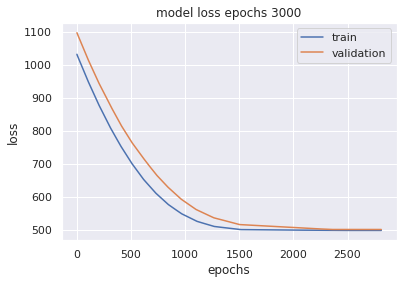

In [120]:
if ci == False:
  input_size = 5
else:
  input_size = 7
  
layer_units = [76, 38, 19, 19, 9, 1]

nn_model = build_model(input_size, layer_units, summary=False)

epochs_arr = [3000]

for e in epochs_arr:
  print('-------------- NN epochs tested '+str(e)+' --------------')
  history, nn_model = train_nn_model(x_train, y_train, x_test, y_test, nn_model, epochs=e, batch_size=16, params_callback=('loss', 200), monitor_model= False, verbose=0)

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss epochs {}'.format(e))
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['train', 'validation'], loc='best')
  plt.savefig(path+"/Spectrum/NN/revised_NN_loss/NN_loss_epochs_"+str(e)+".png")
  plt.show()

In [80]:
preds = nn_model.predict(x_test, batch_size=16, verbose=0)  
print(preds)

[[1.08551282e+03]
 [2.77044800e+02]
 [1.00108795e+03]
 [1.21967505e+03]
 [5.93016907e+02]
 [1.31122974e+03]
 [1.49246375e+03]
 [1.00501190e+03]
 [1.62377539e+03]
 [8.40027222e+02]
 [2.34542969e+03]
 [1.35382922e+03]
 [8.03228149e+02]
 [3.61350037e+02]
 [7.43935974e+02]
 [1.84790845e+03]
 [1.00248914e+03]
 [1.81790039e+03]
 [1.53538269e+03]
 [1.59466931e+03]
 [1.54351746e+03]
 [1.55099390e+03]
 [1.98821899e+03]
 [1.16758899e+03]
 [1.63584692e+03]
 [8.73955078e+02]
 [1.33479919e+03]
 [1.14333740e+03]
 [2.04579163e+03]
 [9.27915039e+02]
 [8.26729736e+02]
 [9.38828003e+02]
 [1.43492517e+03]
 [7.24399719e+02]
 [1.56657031e+03]
 [1.08585046e+03]
 [1.24970203e+03]
 [1.79490735e+03]
 [1.68064709e+03]
 [1.84668121e+02]
 [1.37773047e+03]
 [3.07162811e+02]
 [1.40126611e+03]
 [1.27895117e+03]
 [1.72657703e+03]
 [1.39659058e+03]
 [9.92040710e+02]
 [9.22225891e+02]
 [1.55812085e+03]
 [1.70217346e+03]
 [1.35858289e+03]
 [1.67109253e+03]
 [5.81326294e+02]
 [1.06989270e+03]
 [1.06325415e+03]
 [7.843325

In [81]:
print(y_test)

[ 560. 1840. 1920. 1200.  320.  880. 1680.  320. 1360. 1040.  240. 1840.
  400. 1680.  720.  240.  720.  720. 1200. 1440. 2000. 1200.  400.  480.
  240. 1120. 1040.  720.  560. 1360. 1520.  720.  560.  800. 1440. 1440.
  720. 1520. 1680. 1600. 1520. 1200. 1200.  480. 1280.  160. 2000.  160.
 1360. 1840. 1520. 1760.  480. 1200.  480.  560. 1040. 1840.  880.  960.
 1840. 1040.  160. 1760. 1360.  160. 1520. 1520.   80.  640.  960. 1280.
 1280.  960. 1760. 1120.  480.  800. 1600. 1760.  880. 1520.   80.  240.
 1200.  800. 1040.  880.   80.  800.  480. 1680. 1440. 1840.  240.  400.
 1760. 1760.  720.  240.  640. 1840.  720. 1200. 1840. 1280.   80.  960.
 1440. 1920.  480.   80. 2000. 1760. 1520.  560. 1680.  400. 1920. 1440.
 1200. 1440. 1600. 1520.  320.  720.  640.  160.  800. 1600. 1920.  960.
  160. 2000.  640. 1520. 1040.  800.  720.  160.  320. 1360.  400.  640.
 1760.  640.  800.  160.  640.  880.  240. 1920. 1440. 1040. 1360.  640.
  560.  480. 1120. 2000.  320.  720.  160. 1440. 15

-------------- NN epochs tested 3000 --------------


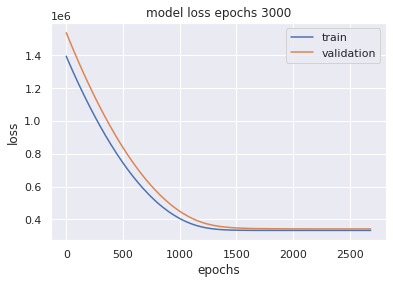

In [85]:
input_size = 7
layer_units = [76, 38, 19, 19, 9, 1]

nn_model = build_model(input_size, layer_units, summary=False)

epochs_arr = [3000]

for e in epochs_arr:
  print('-------------- NN epochs tested '+str(e)+' --------------')
  history, nn_model = train_nn_model(x_train, y_train, x_test, y_test, nn_model, epochs=e, batch_size=16, params_callback=('loss', 200), monitor_model= False, verbose=0)

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss epochs {}'.format(e))
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['train', 'validation'], loc='best')
  plt.savefig(path+"/Spectrum/NN/revised_NN_loss/NN_loss_epochs_"+str(e)+".png")
  plt.show()

In [86]:
preds = nn_model.predict(x_test, batch_size=16, verbose=0)  
print(preds)

[[1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]
 [1035.1202]

In [87]:
print(y_test)

[ 560. 1840. 1920. 1200.  320.  880. 1680.  320. 1360. 1040.  240. 1840.
  400. 1680.  720.  240.  720.  720. 1200. 1440. 2000. 1200.  400.  480.
  240. 1120. 1040.  720.  560. 1360. 1520.  720.  560.  800. 1440. 1440.
  720. 1520. 1680. 1600. 1520. 1200. 1200.  480. 1280.  160. 2000.  160.
 1360. 1840. 1520. 1760.  480. 1200.  480.  560. 1040. 1840.  880.  960.
 1840. 1040.  160. 1760. 1360.  160. 1520. 1520.   80.  640.  960. 1280.
 1280.  960. 1760. 1120.  480.  800. 1600. 1760.  880. 1520.   80.  240.
 1200.  800. 1040.  880.   80.  800.  480. 1680. 1440. 1840.  240.  400.
 1760. 1760.  720.  240.  640. 1840.  720. 1200. 1840. 1280.   80.  960.
 1440. 1920.  480.   80. 2000. 1760. 1520.  560. 1680.  400. 1920. 1440.
 1200. 1440. 1600. 1520.  320.  720.  640.  160.  800. 1600. 1920.  960.
  160. 2000.  640. 1520. 1040.  800.  720.  160.  320. 1360.  400.  640.
 1760.  640.  800.  160.  640.  880.  240. 1920. 1440. 1040. 1360.  640.
  560.  480. 1120. 2000.  320.  720.  160. 1440. 15

In [ ]:
print('Training model with monitor for best model only...')
history = train_nn_model(x_train, y_train, x_test, y_test, nn_model, epochs=5000, batch_size=32, params_callback=('loss', 200), monitor_model= True, verbose=0)

Training model with monitor for best model only...


-------------- NN epochs tested 500 --------------


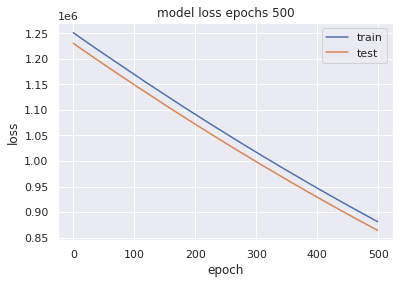

-------------- NN epochs tested 1000 --------------


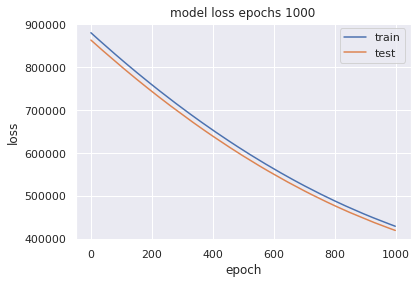

-------------- NN epochs tested 2000 --------------


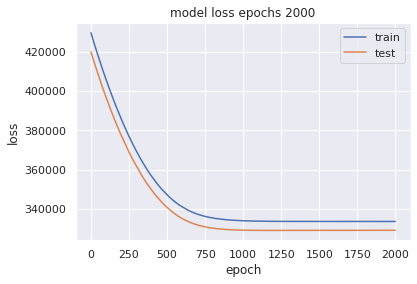

-------------- NN epochs tested 5000 --------------


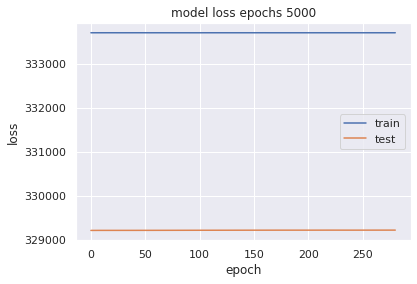

In [ ]:
epochs_arr = [500, 1000, 2000, 5000]

for e in epochs_arr:
  print('-------------- NN epochs tested '+str(e)+' --------------')
  history, nn_model = train_nn_model(x_train, y_train, x_test, y_test, nn_model, epochs=e, batch_size=32, params_callback=('loss', 200), monitor_model= False, verbose=0)

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss epochs {}'.format(e))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig(path+"/Spectrum/NN/revised_NN_loss/NN_loss_epochs_"+str(e)+".png")
  plt.show()

In [ ]:
def predict_test(model_ann, X_test, Y_test, remove_outliers=5, params_freq_reference = (10, 30), all_plots=True, epochs_num=600, training_data=False):
  print('Results (freq_'+str(params_freq_reference[0])+'_reference_'+str(params_freq_reference[1])+')')
  # Predit
  start_time = time.time()
  Y_test_pred=model_ann.predict(X_test)
  pred=list(Y_test_pred)

  time_eval_ann=time.time()-start_time

  dist_min=80
  dist_max=2000

  real=list(Y_test)
  real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
  real_abs=[int(np.round(i)) for i in real_abs]
  pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

  print('Real_abs:')
  print(real_abs)
  print('Pred_abs:')
  print(pred_abs)

  error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
  error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))

  error_v2_Q1 = np.percentile(error_v2, remove_outliers, interpolation = 'midpoint')
  error_v2_Q3 = np.percentile(error_v2, 100-remove_outliers,interpolation = 'midpoint')
  error_v2_IQR = error_v2_Q3 - error_v2_Q1
  error_v2_lower = error_v2_Q1-1.5*error_v2_IQR
  error_v2_upper = error_v2_Q3+1.5*error_v2_IQR

  error_v2_filtered = []
  idx_cnt = 0
  idx_filtered = []
  for e in error_v2:
    if e>=error_v2_lower and e<=error_v2_upper:
      error_v2_filtered.append(e)
      idx_filtered.append(idx_cnt)
    idx_cnt += 1

  filtered_real_abs = [real_abs[i] for i in idx_filtered]
  filtered_pred_abs = [pred_abs[i] for i in idx_filtered]

  if all_plots == True:
    res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
    res.to_csv(path+"/Spectrum/NN/revised_NN_results_error/mod_bootstraped_new_data_results_curve_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".csv", header=True, index=False)

    res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
    res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/mod_bootstraped_new_data_results_deltas_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".csv", header=True, index=False)
    
    plt.plot(real_abs,error,'bo')
    plt.xlabel('Distances') 
    plt.ylabel('Error') 
    plt.title("Results Curve (freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
    plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/mod_bootstraped_new_data_results_curve_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".png")
    plt.show()
    
    plt.plot(real_abs,error_v2,'bo')
    plt.xlabel('Distances') 
    plt.ylabel('Error') 
    plt.title("Results Deltas (freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
    plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/bootstraped_new_data_results_deltas_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".png")

    # Filtered Outliers
    plt.plot(filtered_real_abs,error_v2_filtered,'bo')
    plt.xlabel('Distances') 
    plt.ylabel('Error') 
    plt.title("Results Deltas Filtered (Outliers_Removed_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
    plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/bootstraped_new_data_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".png")
    plt.show()
  else:
    res_v2=pd.DataFrame({"dist":filtered_real_abs,"pred":filtered_pred_abs,"error":error_v2_filtered})
    # Filtered Outliers
    plt.plot(filtered_real_abs,error_v2_filtered,'bo')
    plt.xlabel('Distances') 
    plt.ylabel('Error') 
    plt.title("Results Deltas Filtered (Outliers_Removed_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
    if training_data == False:
      res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/mod_bootstraped_new_data_Testing_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".csv", header=True, index=False)
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/bootstraped_new_data_Testing_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".png")   
    else:
      res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/mod_bootstraped_new_data_Training_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".csv", header=True, index=False)
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/bootstraped_new_data_Training_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".png")
    plt.show()

# Validation

In [ ]:
train_df = pd.read_csv(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_new_data_training_data_NN_freq_10_reference_30.csv")
test_df = pd.read_csv(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_new_data_testing_data_NN_freq_10_reference_30.csv")

reference_freq_data_df = pd.read_csv(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_10_reference_30.csv")
sample_freq_data_df = pd.read_csv(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_10_reference_30.csv")

with open(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_traininig_Rows_NN_freq_10_reference_30.pkl", 'rb') as f:
  rows_training = pickle.load(f)
with open(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_testing_Rows_NN_freq_10_reference_30.pkl", 'rb') as f:
  rows_testing = pickle.load(f) 

In [ ]:
# load best NN model
new_model = tf.keras.models.load_model(path+"/Spectrum/NN/revised_NNs/NN_epochs_2750.h5")
# Show the model architecture
#new_model.summary()
predictions = new_model.predict(x_test)
predictions.shape
#predict_test(nn_model, Y_test, X_test, remove_outliers=5, params_freq_reference = (10, 30), all_plots=False, epochs_num='test', training_data=False)

(350, 1)

In [ ]:
#sample_freq_data_df
#distance_reference_df
#selected_rows = rows_training
def get_features(sample_freq_data_df, reference_freq_data_df, selected_rows, test_references_params):
  data_distance = []
  data_mean = []
  data_std = []
  data_pearson_min = []
  data_pearson_mean = []
  data_pearson_max = []
  data_CI_lower = []
  data_CI_upper = []

  if test_references_params[0] == True: # Test reference distance portion
    reference_freq_data_df = reference_freq_data_df.loc[reference_freq_data_df['Distance_km'] == test_references_params[1]]

  for row_idx in tqdm(selected_rows):
    data_Y = sample_freq_data_df.iloc[row_idx,3] # distance of row selected
    data_X = np.array(sample_freq_data_df.iloc[row_idx,6:sample_freq_data_df.shape[1]]) #array of data in row selected
    data_distance.append(data_Y)
    data_std.append(np.std(data_X))
    data_mean.append(np.mean(data_X))

    data_ci = st.t.interval(alpha=0.90, df=len(data_X)-1, loc=np.mean(data_X), scale=st.sem(data_X))
    data_confidence_int_lower = data_ci[0]
    data_confidence_int_upper = data_ci[1]

    # Get reference data -----------------
    distance_reference_df = reference_freq_data_df.loc[reference_freq_data_df['Distance_km'] == data_Y]
    if distance_reference_df.empty:
      distance_reference_df = reference_freq_data_df.copy()

    pearson_vals = []
    confidence_vals_lower = []
    confidence_vals_upper = []
    for reference_row in range(0, distance_reference_df.shape[0]):
      reference_X = np.array(distance_reference_df.iloc[reference_row,6:distance_reference_df.shape[1]])
      pearson_vals.append(round(pearsonr(data_X, reference_X)[0], 5))

      reference_ci = st.t.interval(alpha=0.90, df=len(reference_X)-1, loc=np.mean(reference_X), scale=st.sem(reference_X))
      reference_confidence_int_lower = reference_ci[0]
      confidence_vals_lower.append(round(abs(reference_confidence_int_lower - data_confidence_int_lower), 5))
      reference_confidence_int_upper = reference_ci[1]
      confidence_vals_upper.append(round(abs(reference_confidence_int_upper - data_confidence_int_upper),5))

    data_pearson_min.append(np.min(pearson_vals))
    data_pearson_mean.append(np.mean(pearson_vals))    
    data_pearson_max.append(np.max(pearson_vals))

    data_CI_lower.append(np.min(confidence_vals_lower))
    data_CI_upper.append(np.min(confidence_vals_upper))

  data = {'distance':data_distance,
                  'mean':data_mean,
                  'std':data_std,
                  'pearson_min':data_pearson_min,
                  'pearson_mean':data_pearson_mean,
                  'pearson_max':data_pearson_max,
                  'delta_CI_min':data_CI_lower,
                  'delta_CI_max':data_CI_upper}

  data_df = pd.DataFrame(data)
  
  return data_df

100%|██████████| 2350/2350 [01:58<00:00, 19.83it/s]


Results (freq_10_reference_30)
Real_abs:
[480, 640, 720, 880, 1280, 1440, 400, 160, 960, 1600, 960, 2000, 1600, 80, 800, 1360, 1200, 640, 1360, 320, 1040, 2000, 1760, 160, 1120, 1280, 320, 1200, 800, 1120, 1360, 1520, 1280, 480, 1440, 320, 160, 560, 1840, 1360, 480, 320, 1680, 1360, 1280, 960, 480, 560, 1920, 1440, 1040, 240, 1520, 80, 1840, 880, 640, 480, 960, 1680, 1600, 720, 640, 160, 400, 1280, 1840, 1280, 960, 880, 400, 1920, 1440, 1040, 1920, 1600, 1200, 1760, 1360, 1280, 1360, 1760, 1920, 640, 400, 1120, 560, 1280, 2000, 640, 800, 720, 720, 1760, 1920, 1680, 1600, 1040, 800, 1120, 960, 1680, 720, 320, 560, 1200, 480, 1120, 240, 2000, 1520, 880, 640, 1440, 1520, 400, 80, 720, 1360, 320, 1680, 400, 800, 960, 480, 320, 1360, 1120, 400, 400, 1520, 480, 800, 1840, 640, 480, 1040, 240, 1520, 1920, 1520, 1600, 1040, 1360, 1680, 720, 720, 1040, 160, 160, 1120, 880, 1840, 2000, 640, 560, 1280, 320, 1680, 80, 1280, 1200, 2000, 1920, 800, 80, 880, 320, 560, 1520, 1760, 480, 1920, 1360, 200

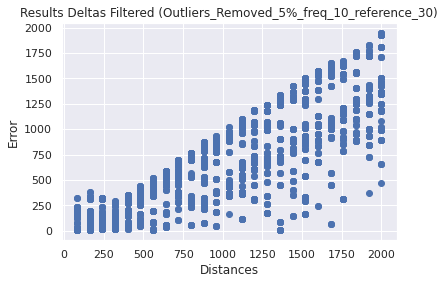

[0.20833333333333334, 0.2916666666666667, 0.3333333333333333, 0.4166666666666667, 0.625, 0.7083333333333334, 0.16666666666666666, 0.041666666666666664, 0.4583333333333333, 0.7916666666666666, 0.4583333333333333, 1.0, 0.7916666666666666, 0.0, 0.375, 0.6666666666666666, 0.5833333333333334, 0.2916666666666667, 0.6666666666666666, 0.125, 0.5, 1.0, 0.875, 0.041666666666666664, 0.5416666666666666, 0.625, 0.125, 0.5833333333333334, 0.375, 0.5416666666666666, 0.6666666666666666, 0.75, 0.625, 0.20833333333333334, 0.7083333333333334, 0.125, 0.041666666666666664, 0.25, 0.9166666666666666, 0.6666666666666666, 0.20833333333333334, 0.125, 0.8333333333333334, 0.6666666666666666, 0.625, 0.4583333333333333, 0.20833333333333334, 0.25, 0.9583333333333334, 0.7083333333333334, 0.5, 0.08333333333333333, 0.75, 0.0, 0.9166666666666666, 0.4166666666666667, 0.2916666666666667, 0.20833333333333334, 0.4583333333333333, 0.8333333333333334, 0.7916666666666666, 0.3333333333333333, 0.2916666666666667, 0.0416666666666

100%|██████████| 2350/2350 [01:50<00:00, 21.19it/s]


Results (freq_10_reference_30)
Real_abs:
[480, 640, 720, 880, 1280, 1440, 400, 160, 960, 1600, 960, 2000, 1600, 80, 800, 1360, 1200, 640, 1360, 320, 1040, 2000, 1760, 160, 1120, 1280, 320, 1200, 800, 1120, 1360, 1520, 1280, 480, 1440, 320, 160, 560, 1840, 1360, 480, 320, 1680, 1360, 1280, 960, 480, 560, 1920, 1440, 1040, 240, 1520, 80, 1840, 880, 640, 480, 960, 1680, 1600, 720, 640, 160, 400, 1280, 1840, 1280, 960, 880, 400, 1920, 1440, 1040, 1920, 1600, 1200, 1760, 1360, 1280, 1360, 1760, 1920, 640, 400, 1120, 560, 1280, 2000, 640, 800, 720, 720, 1760, 1920, 1680, 1600, 1040, 800, 1120, 960, 1680, 720, 320, 560, 1200, 480, 1120, 240, 2000, 1520, 880, 640, 1440, 1520, 400, 80, 720, 1360, 320, 1680, 400, 800, 960, 480, 320, 1360, 1120, 400, 400, 1520, 480, 800, 1840, 640, 480, 1040, 240, 1520, 1920, 1520, 1600, 1040, 1360, 1680, 720, 720, 1040, 160, 160, 1120, 880, 1840, 2000, 640, 560, 1280, 320, 1680, 80, 1280, 1200, 2000, 1920, 800, 80, 880, 320, 560, 1520, 1760, 480, 1920, 1360, 200

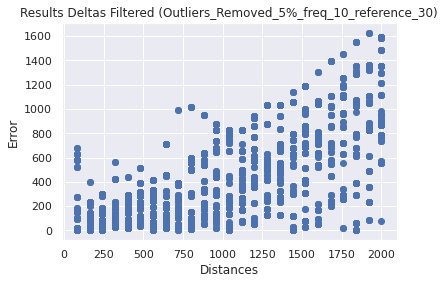

[0.20833333333333334, 0.2916666666666667, 0.3333333333333333, 0.4166666666666667, 0.625, 0.7083333333333334, 0.16666666666666666, 0.041666666666666664, 0.4583333333333333, 0.7916666666666666, 0.4583333333333333, 1.0, 0.7916666666666666, 0.0, 0.375, 0.6666666666666666, 0.5833333333333334, 0.2916666666666667, 0.6666666666666666, 0.125, 0.5, 1.0, 0.875, 0.041666666666666664, 0.5416666666666666, 0.625, 0.125, 0.5833333333333334, 0.375, 0.5416666666666666, 0.6666666666666666, 0.75, 0.625, 0.20833333333333334, 0.7083333333333334, 0.125, 0.041666666666666664, 0.25, 0.9166666666666666, 0.6666666666666666, 0.20833333333333334, 0.125, 0.8333333333333334, 0.6666666666666666, 0.625, 0.4583333333333333, 0.20833333333333334, 0.25, 0.9583333333333334, 0.7083333333333334, 0.5, 0.08333333333333333, 0.75, 0.0, 0.9166666666666666, 0.4166666666666667, 0.2916666666666667, 0.20833333333333334, 0.4583333333333333, 0.8333333333333334, 0.7916666666666666, 0.3333333333333333, 0.2916666666666667, 0.0416666666666

100%|██████████| 2350/2350 [01:47<00:00, 21.79it/s]


Results (freq_10_reference_30)
Real_abs:
[480, 640, 720, 880, 1280, 1440, 400, 160, 960, 1600, 960, 2000, 1600, 80, 800, 1360, 1200, 640, 1360, 320, 1040, 2000, 1760, 160, 1120, 1280, 320, 1200, 800, 1120, 1360, 1520, 1280, 480, 1440, 320, 160, 560, 1840, 1360, 480, 320, 1680, 1360, 1280, 960, 480, 560, 1920, 1440, 1040, 240, 1520, 80, 1840, 880, 640, 480, 960, 1680, 1600, 720, 640, 160, 400, 1280, 1840, 1280, 960, 880, 400, 1920, 1440, 1040, 1920, 1600, 1200, 1760, 1360, 1280, 1360, 1760, 1920, 640, 400, 1120, 560, 1280, 2000, 640, 800, 720, 720, 1760, 1920, 1680, 1600, 1040, 800, 1120, 960, 1680, 720, 320, 560, 1200, 480, 1120, 240, 2000, 1520, 880, 640, 1440, 1520, 400, 80, 720, 1360, 320, 1680, 400, 800, 960, 480, 320, 1360, 1120, 400, 400, 1520, 480, 800, 1840, 640, 480, 1040, 240, 1520, 1920, 1520, 1600, 1040, 1360, 1680, 720, 720, 1040, 160, 160, 1120, 880, 1840, 2000, 640, 560, 1280, 320, 1680, 80, 1280, 1200, 2000, 1920, 800, 80, 880, 320, 560, 1520, 1760, 480, 1920, 1360, 200

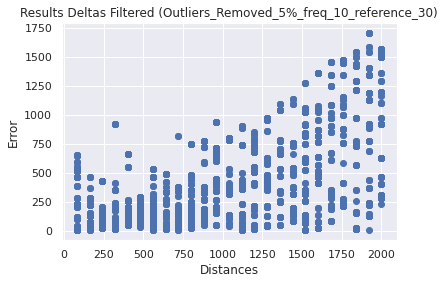

[0.20833333333333334, 0.2916666666666667, 0.3333333333333333, 0.4166666666666667, 0.625, 0.7083333333333334, 0.16666666666666666, 0.041666666666666664, 0.4583333333333333, 0.7916666666666666, 0.4583333333333333, 1.0, 0.7916666666666666, 0.0, 0.375, 0.6666666666666666, 0.5833333333333334, 0.2916666666666667, 0.6666666666666666, 0.125, 0.5, 1.0, 0.875, 0.041666666666666664, 0.5416666666666666, 0.625, 0.125, 0.5833333333333334, 0.375, 0.5416666666666666, 0.6666666666666666, 0.75, 0.625, 0.20833333333333334, 0.7083333333333334, 0.125, 0.041666666666666664, 0.25, 0.9166666666666666, 0.6666666666666666, 0.20833333333333334, 0.125, 0.8333333333333334, 0.6666666666666666, 0.625, 0.4583333333333333, 0.20833333333333334, 0.25, 0.9583333333333334, 0.7083333333333334, 0.5, 0.08333333333333333, 0.75, 0.0, 0.9166666666666666, 0.4166666666666667, 0.2916666666666667, 0.20833333333333334, 0.4583333333333333, 0.8333333333333334, 0.7916666666666666, 0.3333333333333333, 0.2916666666666667, 0.0416666666666

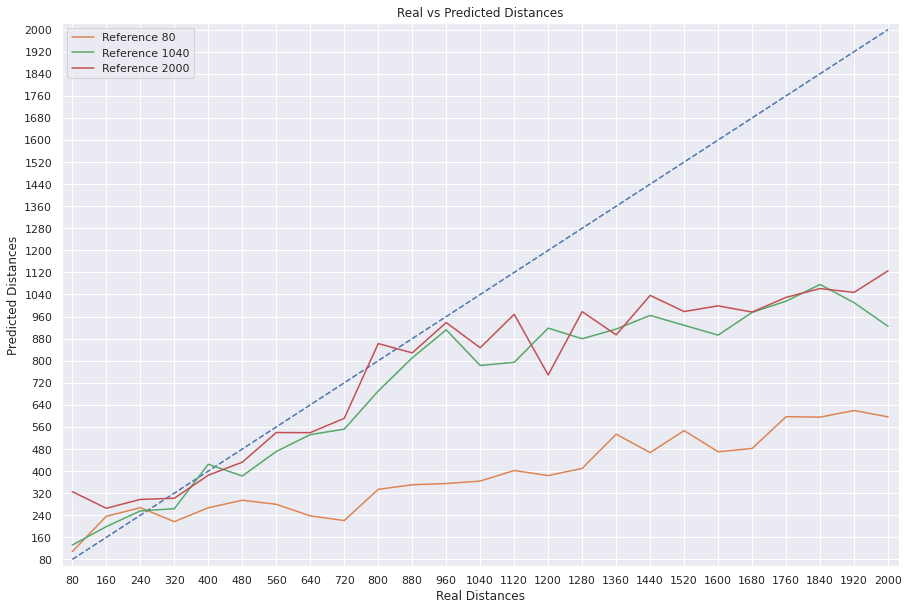

[108.55875, 236.10194, 267.4965, 216.79442, 267.15558, 294.367, 279.6416, 237.7248, 220.8444, 333.80594, 350.5385, 354.9721, 363.914, 402.16495, 383.81595, 409.65015, 533.78674, 467.01028, 546.76587, 470.0927, 482.06223, 597.23334, 595.63306, 619.5871, 596.5751]
[132.02087, 198.86575, 255.75688, 263.75577, 424.83435, 382.1834, 471.0786, 532.235, 551.98694, 690.1686, 810.4689, 911.9743, 782.791, 794.2273, 918.1833, 879.5402, 914.74347, 964.197, 928.3225, 892.85315, 975.3061, 1015.8847, 1076.4102, 1010.3401, 924.6137]
[325.54333, 265.2486, 297.33698, 301.59113, 385.0743, 432.22815, 539.6832, 539.3782, 591.22437, 862.2216, 828.5306, 938.3111, 847.01825, 968.2528, 748.4609, 977.9089, 893.8444, 1036.6553, 978.2592, 998.86194, 976.3532, 1029.6389, 1061.5123, 1047.6642, 1125.8662]
-----------------------------------------------------------------------


In [ ]:
num_of_freq_selected = 10
reference_amt = 30

# Load network
from keras.models import load_model
mm = KerasRegressor(build_fn=ann, epochs=2500, batch_size=8, verbose=0)
mm.model = load_model(path+"/Spectrum/NN/NNs/mod_bootstraped_final_new_data_NN_model_freq_10_reference_30.h5")

res = {}
reference_test = [80, 1040, 2000]
distances = [x*80 for x in range(1, 26)]

for r in reference_test:
  new_test_df = get_features(sample_freq_data_df, reference_freq_data_df, rows_testing, test_references_params=(True, r))
  #new_test_df = test_df.copy()
  
  dist_min=80 # 80
  dist_max=2000 # 2000

  Y = new_test_df.iloc[:, 0].to_numpy()
  X = new_test_df.iloc[:, 1:(new_test_df.shape[1])]

  Y_test = (Y - Y.min())/ (Y.max() - Y.min())
  X_test = (X-X.min())/ (X.max() - X.min())

  predict_test(mm, Y_test, X_test, remove_outliers=5, params_freq_reference = (10, 30), all_plots=False, epochs_num='test', training_data=False)
  # Prediction
  Y_test_pred=mm.predict(X_test)
  pred=list(Y_test_pred)
  real=list(Y_test)
  print(real)
  print(pred)

  real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
  real_abs=[int(np.round(i)) for i in real_abs]
  pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar
  
  print(real_abs)
  print(pred_abs)

  real_split ={}
  for d in distances:
    matches = [i for i in range(0,len(real_abs)) if real_abs[i]==d]
    real_split[d] = matches
  
  pred_res = []
  pred_m = []
  for d_real, matches_idx in real_split.items():
    pred_m = [pred_abs[i] for i in matches_idx]
    Q1 = np.percentile(pred_m, 25,interpolation = 'midpoint')
    Q3 = np.percentile(pred_m, 75,interpolation = 'midpoint')

    IQR = Q3 - Q1
    upper = Q3+1.5*IQR
    lower = Q1-1.5*IQR
    filtered_pred_m = []
    for v in pred_m:
      if v <= upper and v >= lower:
        filtered_pred_m.append(v)
    pred_res.append(round(np.mean(filtered_pred_m), 5))
  
  res[r] = pred_res
print('-----------------------------------------------------------------------')
print('Resuslts')

plt.figure(figsize=(15, 10))
plt.plot(distances, distances,  linestyle='--')
for re in reference_test:
  plt.plot(distances, res[re], label='Reference '+str(re))

plt.title('Real vs Predicted Distances')
plt.xlabel('Real Distances')
plt.ylabel('Predicted Distances')
plt.xlim(np.min(distances)-25, np.max(distances)+25)
plt.ylim(np.min(distances)-25, np.max(distances)+25)
plt.yticks(distances)
plt.xticks(distances)
plt.legend(loc="best")
plt.show()

for re in reference_test:
  print(res[re])

print('-----------------------------------------------------------------------')